In [6]:
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
from scipy import stats,optimize
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import math

In [7]:
def get_breath_data(filepath,):
    file1 = open(filepath, 'r')
    if (file1.readline() == '\n'):
        operating_system = 'windows'
    else:
        operating_system = 'other'
    file1.close()
    if (operating_system == 'windows'):
        raw_spiro = pd.read_csv(filepath,header=8) #earlier rows contain patient information
        raw_spiro = raw_spiro.drop(['Unnamed: 4'], axis=1)
    else:
        raw_spiro = pd.read_csv(filepath)
    raw_spiro['Date'] = pd.to_datetime(raw_spiro['Date'])
    raw_spiro['unixDate']= raw_spiro['Date']
    raw_spiro['unixDate']= raw_spiro['unixDate'].astype(np.int64)// 10**9
    raw_spiro['unixDate'] = raw_spiro['unixDate']/86400

    #get time in datetime format
    if (operating_system == 'windows'):
        raw_spiro = raw_spiro[raw_spiro['Time'].str.find('0')!=0]
        raw_spiro['Time']=pd.to_datetime(raw_spiro['Time'],format= '%I:%M %p' )
    else:
        raw_spiro['Time']=pd.to_datetime(raw_spiro['Time'],format= '%H:%M' )
        raw_spiro=raw_spiro.rename(columns={"PEF": "PEF(l/min)","FEV1":"FEV1(l)"})
    raw_spiro['unixTime'] = raw_spiro['Time'].apply(lambda x: timedelta(hours=x.hour, minutes=x.minute).total_seconds())
    raw_spiro['Hour']=raw_spiro['Time'].apply(lambda x: x.hour)
    return raw_spiro

In [8]:
#set this to the locations of your files
raw_spiro=get_breath_data('./D.csv')
raw_spiro = raw_spiro.reset_index()
raw_spiro = raw_spiro.drop(['index'],axis=1)
raw_spiro.to_csv('raw_spiro.csv',index=False)

In [3]:
#linear regression which plots and gives coefficient and R-squared
def lin_reg_plot(X,Y):
    regr = linear_model.LinearRegression()
    X = X.values.reshape(-1, 1)
    Y = Y.values.reshape(-1, 1)
    regr.fit(X, Y)
    Y_pred = regr.predict(X)    
    # Plot outputs
    plt.figure(figsize=(8, 8))
    plt.plot(X, Y_pred, color='red')
    plt.scatter(X, Y)
    plt.show()
    print('Coefficient: \n', round(regr.coef_[0][0],2))
    print('R-squared: %.2f'
          % r2_score(Y, Y_pred))

In [5]:
Y = raw_spiro['PEF(l/min)']
X = raw_spiro[['FEV1(l)','Hour']]

mod = sm.OLS(Y,X)
fit = mod.fit()
summary = fit.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             PEF(l/min)   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          1.082e+04
Date:                Tue, 07 Apr 2020   Prob (F-statistic):                   4.55e-179
Time:                        13:35:22   Log-Likelihood:                         -848.22
No. Observations:                 171   AIC:                                      1700.
Df Residuals:                     169   BIC:                                      1707.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FEV1(l)      150.3725      1.881     79.939      0.000     146.659     154.086
Hour           0.8179      0.345      2.371      0.019       0.137       1.499
==============================================================================
Omnibus:                       72.117   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              447.527
Skew:                           1.406   Prob(JB):                     6.62e-98
Kurtosis:                      10.410   Cond. No.                         10.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

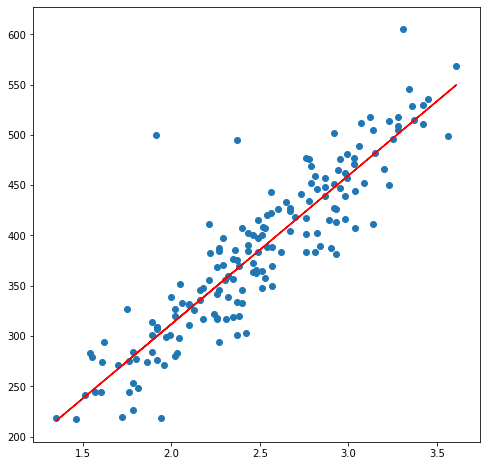

Coefficient: 
 147.67
R-squared: 0.82


In [6]:
lin_reg_plot(raw_spiro['FEV1(l)'],raw_spiro['PEF(l/min)'])
#there's a clear connection between FEV and PEV

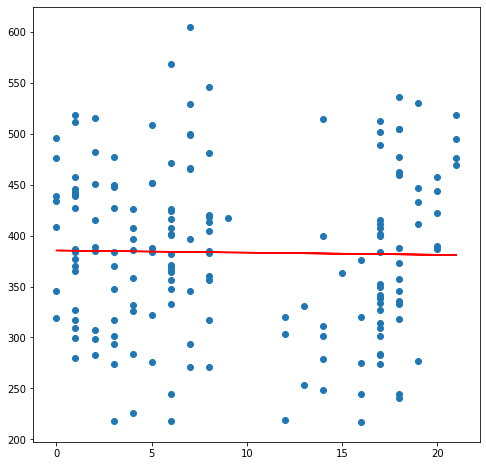

Coefficient: 
 -0.21
R-squared: 0.00


In [7]:
#test hypothesis that breathing gets worse during sleep - sleep is from 22 - 6 - adding buffer
sleepTest = raw_spiro.copy() 
sleepTest = sleepTest.drop(['unixDate'],axis=1)
sleepTest.reset_index(drop=True)
#same data - just starting around sleeptime and setting that to zero
sleepTest.loc[sleepTest['Hour'] <= 22,'Hour'] = sleepTest['Hour']+2
sleepTest.loc[sleepTest['Hour'] >= 22,'Hour'] = sleepTest['Hour']-22
wakeTest = sleepTest.copy()
baseTest = sleepTest.copy()
lin_reg_plot(baseTest['Hour'],baseTest['PEF(l/min)'])

#small increase as day goes on

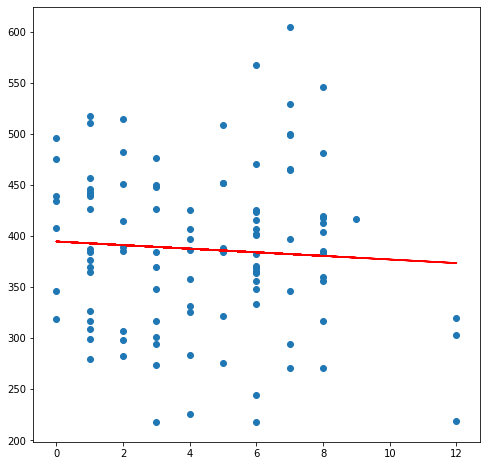

Coefficient: 
 -1.76
R-squared: 0.00


In [8]:
sleepTest = sleepTest.where(sleepTest['Hour']<=12).dropna()
lin_reg_plot(sleepTest['Hour'],sleepTest['PEF(l/min)'])
#decrease during sleep

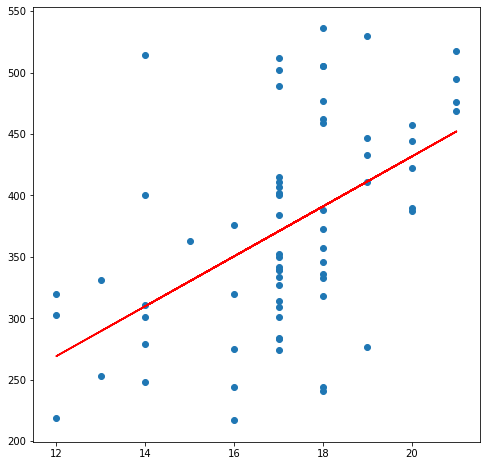

Coefficient: 
 20.31
R-squared: 0.26


In [9]:
wakeTest = wakeTest.where(wakeTest['Hour']>10).dropna()
lin_reg_plot(wakeTest['Hour'],wakeTest['PEF(l/min)'])
#strong increase from wake until near end of day

In [10]:
#let's examine a time series analysis
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=3,center=False).mean()
    rolstd = timeseries.rolling(window=3,center=False).std()
    #Plot rolling statistics:
    plt.figure(figsize=(8, 8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(dfoutput)

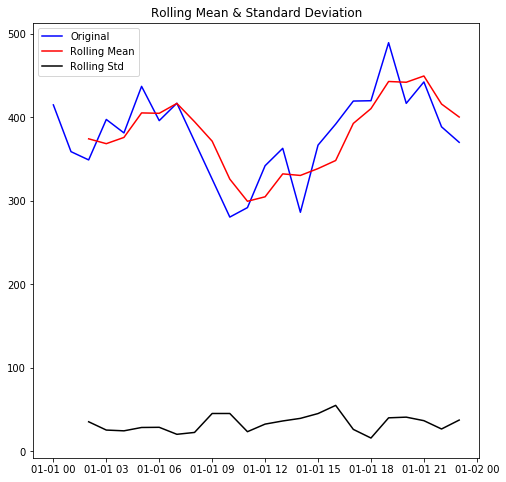

Results of Dickey-Fuller Test:
Test Statistic                 -2.368808
p-value                         0.150734
#Lags Used                      0.000000
Number of Observations Used    23.000000
dtype: float64


In [11]:
#just compare PEF to time
X = raw_spiro.copy()
X = X.set_index('Time')
X = X['PEF(l/min)']
X = X.resample('H').mean()
X = X.interpolate()
test_stationarity(X)

In [12]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [13]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                mse = evaluate_arima_model(dataset, order)
                if mse < best_score:
                    best_score, best_cfg = mse, order
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 1)
solution = evaluate_models(X, p_values, d_values, q_values)

(0, 0, 0) 3083.188705875002
(0, 1, 0) 2702.087424988868
(0, 2, 0) 8336.729173216367
(1, 0, 0) 1965.5172487006905
(1, 1, 0) 2628.217432201138
(1, 2, 0) 3539.992951014216
(2, 0, 0) 2048.4474532222907
(2, 1, 0) 2752.9724543365846
(2, 2, 0) 3537.292610552772
Best ARIMA(1, 0, 0) MSE=1965.517


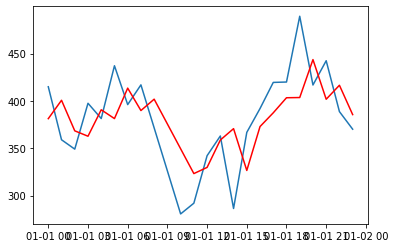

In [14]:
#our time series approximation
model = ARIMA((X),order=(1,0,0),freq='H')
results_AR= model.fit()
plt.plot(X)
plt.plot(results_AR.fittedvalues,color='red')

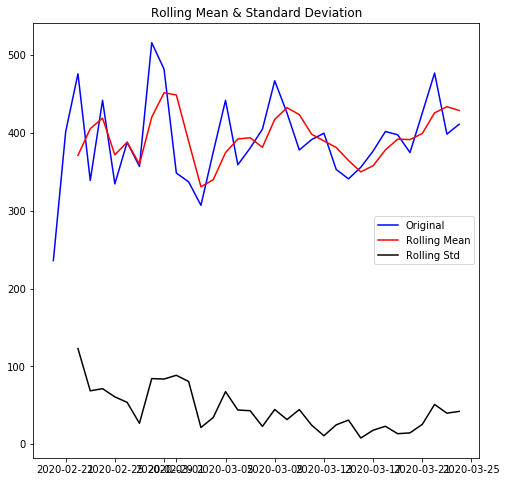

Results of Dickey-Fuller Test:
Test Statistic                 -4.807134
p-value                         0.000053
#Lags Used                     10.000000
Number of Observations Used    23.000000
dtype: float64


In [15]:
#here we are creating a time series by the day
X2 = raw_spiro.copy()
X2 = X2.groupby('Date').mean()
X2.index
X2.set_index(pd.date_range(start=X2.index.min(), end=X2.index.max()), inplace=True)
X2 = X2['PEF(l/min)']

test_stationarity(X2)

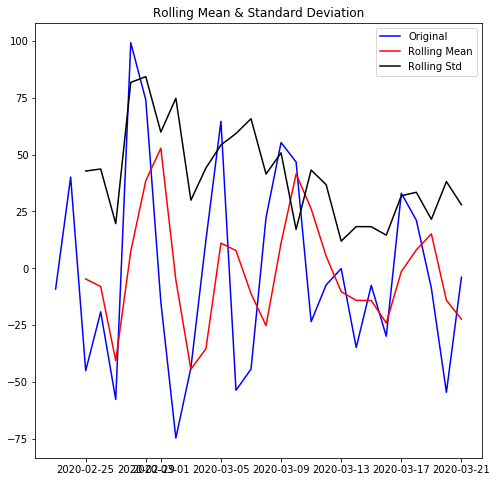

Results of Dickey-Fuller Test:
Test Statistic                 -5.371040
p-value                         0.000004
#Lags Used                      1.000000
Number of Observations Used    26.000000
dtype: float64


In [16]:
#more seasonal analysis once I have more data
decomposition = seasonal_decompose(X2)
trend = decomposition.trend
seasonal = decomposition.seasonal

residual = decomposition.resid
test_stationarity(residual.dropna())

(0, 0, 0) 1289.0468179959546
(0, 1, 0) 1378.8172219094492
(0, 2, 0) 3213.822341836356
(1, 0, 0) 1230.378234361617
(1, 1, 0) 1373.9506077825852
(1, 2, 0) 2811.743914214172
(2, 0, 0) 1359.7437187838707
(2, 1, 0) 1117.5747179327986
(2, 2, 0) 2289.8074527177037
Best ARIMA(2, 1, 0) MSE=1117.575


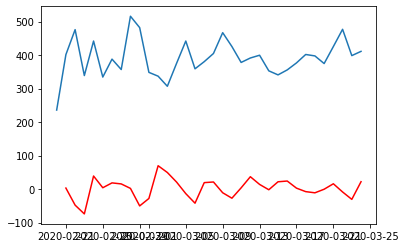

In [18]:
solution = evaluate_models(X2, p_values, d_values, q_values)
model = ARIMA((X2),order=solution,freq='D')
results_AR= model.fit()
plt.plot(X2)
plt.plot(results_AR.fittedvalues,color='red')